**PROBLEM FRAMING**

In this project, you are in the shoes of an electricity utility (e.g., a company like Duke Energy), who is trying to forecast "peak" electricity demand in its service area in order to make decisions about how to operate its fleet of power plants, including staffing and fuel purchase decisions.

Peak demand for each day is the highest value within each 24-hour period. It is often the primary driver operational decisions at power plants, especially about which power plants need to be turned on (which can be time intensive and expensive).

> Here's a typical hourly electric utility demand profile, with the peaks shown:

![picture](https://drive.google.com/uc?export=view&id=1XQaj9yBJ2T2Uj3eILWik3ox-sBZQi2O2)





The date is **July 16, 2020**. The utility is trying to make a forecast about peak demand for the next 7 days:

* July 17
* July 18
* July 19
* July 20
* July 21
* July 22
* July 23

Your job is to make the **most accurate forecast possible**, and then use this forecast to determine an **optimal operating schedule** for the utility's fleet of power plants.

**DATA**

Here's the information that the utility (and you) can use to make a forecast:

**Historical 2019 data**

* Coincident time series of daily average air temperatures and daily peak electricity demand for a recent, historical year (2019)

> Air temperatures are one of the primary drivers of electricity usage for heating and cooling, and have a pretty strong predictive relationship with peak electricity demand

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

from matplotlib import pyplot as plt
from scipy.stats import boxcox

from google.colab import files

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/romulus97/ISE437/main/daily_2019.csv',header=0)
df

,day_of_week,temperature F,peak demand
0,2,64.547500,10641
1,3,53.368750,12733
2,4,51.353750,12558
3,5,51.416250,12388
4,6,52.438750,11788
...,...,...,...
360,5,50.529167,12466
361,6,55.073333,10506
362,7,61.200417,10295
363,1,65.707500,10808


Text(0, 0.5, 'Temperature (degrees F)')

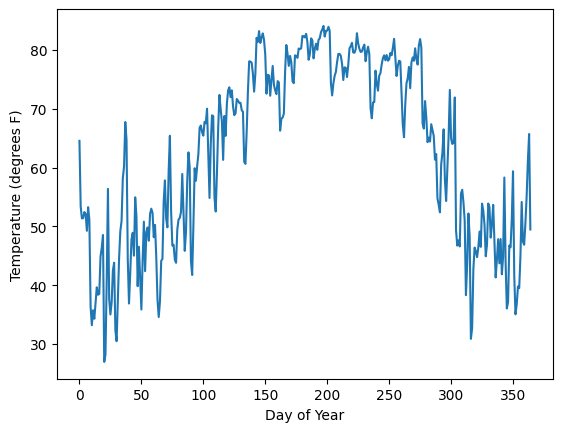

In [ ]:
plt.plot(df['temperature F'])
plt.xlabel('Day of Year')
plt.ylabel('Temperature (degrees F)')

Text(0, 0.5, 'Demand (MWh)')

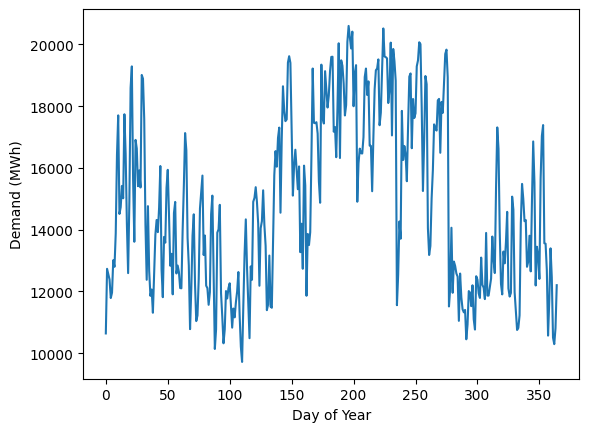

In [ ]:
plt.plot(df['peak demand'])
plt.xlabel('Day of Year')
plt.ylabel('Demand (MWh)')

**Historical Weather Data**

The utility also has access to several recent years of weather data, which allow it to better characterize the fixed and random phenomena associated with air temperature time series.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/romulus97/ISE437/main/daily_historical.csv',header=0)
df

,date,value
0,2010-01-01,41.914167
1,2010-01-02,29.525833
2,2010-01-03,24.523333
3,2010-01-04,25.953750
4,2010-01-05,27.042917
...,...,...
3647,2019-12-27,50.529167
3648,2019-12-28,55.073333
3649,2019-12-29,61.200417
3650,2019-12-30,65.707500


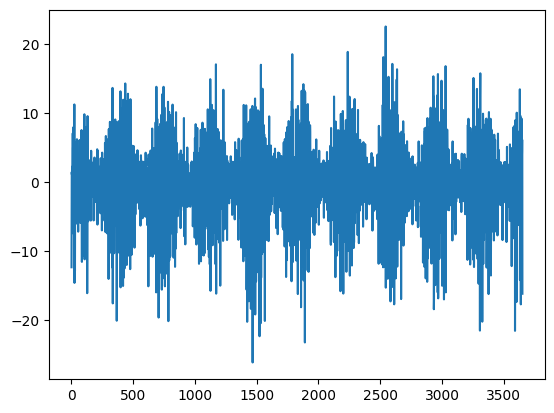

In [ ]:
series = df['value']

# Perform first-order differencing
ts_diff = series.diff()

plt.plot(ts_diff)

Text(0, 0.5, 'Air Temperature (degrees F)')

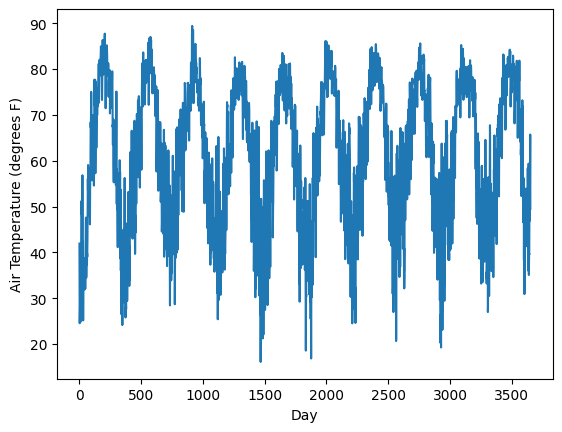

In [ ]:
plt.plot(df['value'])
plt.xlabel('Day')
plt.ylabel('Air Temperature (degrees F)')

Text(0, 0.5, 'Air temp')

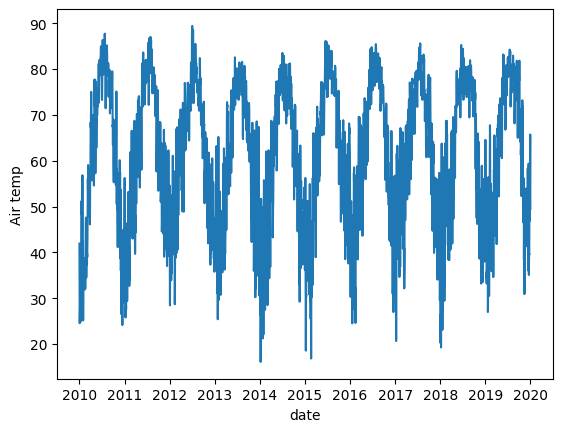

In [ ]:
df['date']= pd.to_datetime(df['date'])
df.index = df['date']
df = df.drop('date', axis=1)

plt.plot(df['value'])

plt.xlabel('date')
plt.ylabel('Air temp')

Text(0.5, 0, 'date')

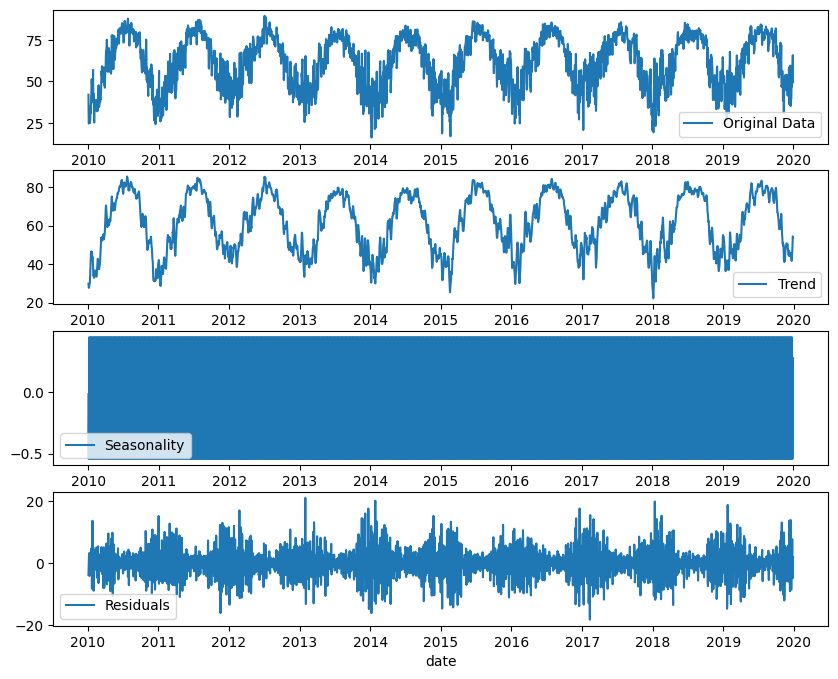

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform STL decomposition
result = seasonal_decompose(df, model='additive')

# Plot the decomposed components
fig, (ax1, ax2, ax3,ax4) = plt.subplots(4, 1, figsize=(10, 8))

ax1.plot(df, label="Original Data")
ax1.legend()

ax2.plot(result.trend,label="Trend")
ax2.legend()

ax3.plot(result.seasonal, label="Seasonality")
ax3.legend()

ax4.plot(result.resid, label="Residuals")
ax4.legend()
ax4.set_xlabel('date')

The average for everyday of the year using the historical data (10 years)

In [ ]:
T = np.zeros((365,10))
for i in range(0,10):
  T[:,i] = result.trend[0+365*i:365+365*i]

mu_T = np.nanmean(T,axis=1)

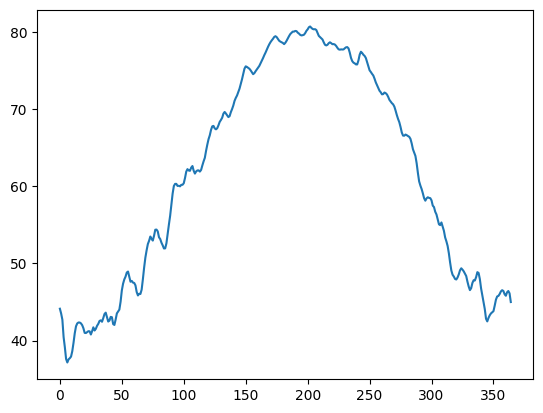

In [ ]:
plt.plot(mu_T)

Cut off right before July 17

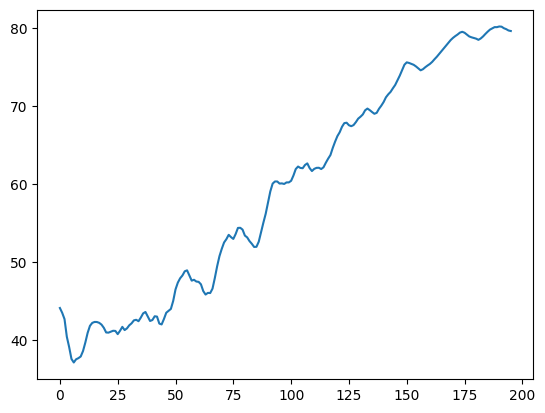

In [ ]:
plt.plot(mu_T[0:196])


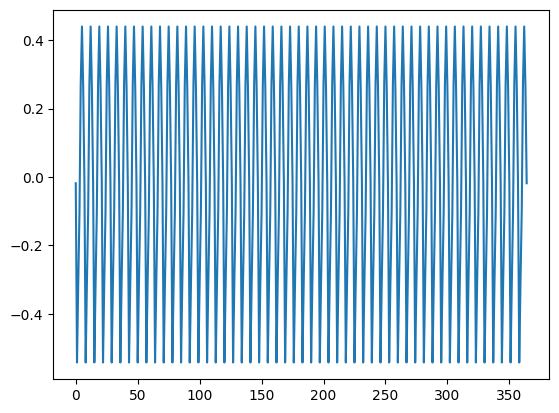

In [ ]:
plt.plot(result.seasonal.values[0:365])

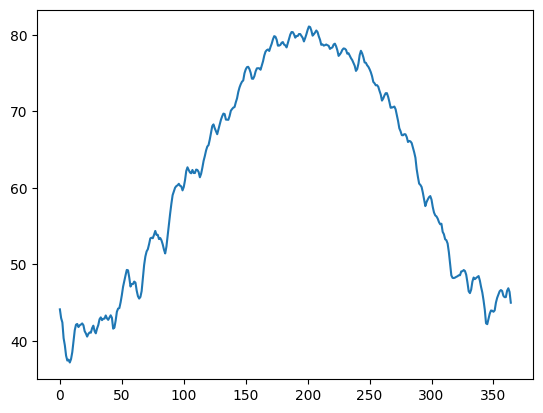

In [ ]:
fixed_phenomena = mu_T + result.seasonal.values[0:365]

plt.plot(fixed_phenomena)

In [ ]:
result.resid

df_r = pd.DataFrame(result.resid)


In [ ]:
df_r = df_r.dropna()
df_r

,resid
date,
2010-01-04,-3.787608
2010-01-05,-1.589222
2010-01-06,0.783180
2010-01-07,2.728092
2010-01-08,3.220588
...,...
2019-12-24,7.710659
2019-12-25,-1.399439
2019-12-26,-4.838991


In [ ]:
july_d = df_r[df_r.index.month.isin([7])]


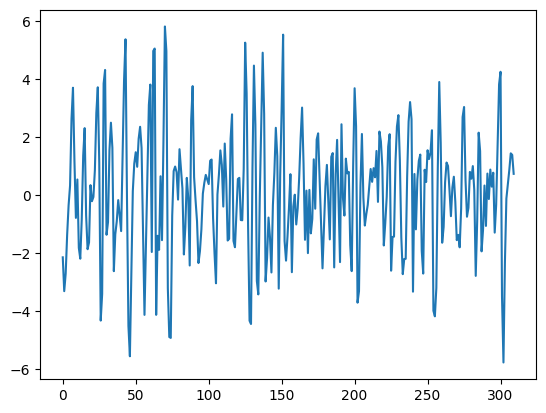

In [ ]:
july_d = july_d.reset_index(drop=True)
plt.plot(july_d)

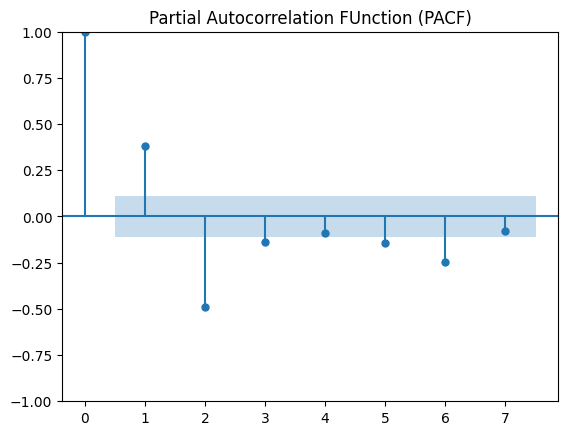

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(july_d, lags = 7)
plt.title("Partial Autocorrelation Function (PACF)") #xy
plt.show()



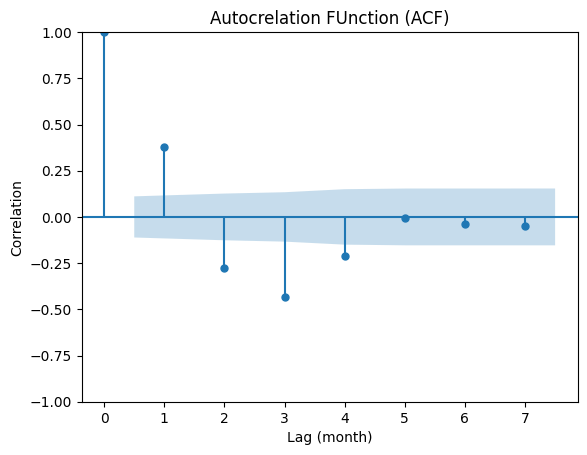

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(july_d, lags = 7)
plt.xlabel('Lag (month)')
plt.ylabel('Correlation')
plt.title("Autocrelation FUnction (ACF)") #xy
plt.show()

In [ ]:
import statsmodels.api as sm

# Fit the ARIMA model
model = sm.tsa.ARIMA(july_d[1:], order=(3,0,4))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  309
Model:                 ARIMA(3, 0, 4)   Log Likelihood                -582.239
Date:                Fri, 26 Apr 2024   AIC                           1182.477
Time:                        16:34:51   BIC                           1216.078
Sample:                             0   HQIC                          1195.911
                                - 309                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0900      0.028      3.270      0.001       0.036       0.144
ar.L1         -0.1198      0.198     -0.607      0.544      -0.507       0.267
ar.L2          0.0927      0.179      0.518      0.6

**Recent Forecast Year (2020) Data**

The last bit of information the utility has (you have) are recent historical temperatures leading up to the forecast day. So, they have the ability to characterize very recent data in terms of how it deviates away from fixed phenomena that typically characterize air temperatures.

In [ ]:
july_2020 = pd.read_csv('https://raw.githubusercontent.com/romulus97/ISE437/main/2020_partial_daily.csv',header=0)

july_2020

,date,temperature
0,1/1/2020,44.617500
1,1/2/2020,43.709167
2,1/3/2020,50.445417
3,1/4/2020,56.667500
4,1/5/2020,43.269583
...,...,...
192,7/12/2020,80.759583
193,7/13/2020,80.494583
194,7/14/2020,80.856667
195,7/15/2020,81.681250


In [ ]:
july_2020['date']= pd.to_datetime(july_2020['date'])
july_2020.index = july_2020['date']
july_2020 = july_2020.drop('date', axis=1)

In [ ]:
#find where july 16 is on average and cut the rest off
#use 2020 data and subtract from average to get residuals

In [ ]:
mu_T_UTD = mu_T[0:197] #avg of 10 years until july 16


In [ ]:
july_2020_UTD = july_2020.values


In [ ]:
mu_T_UTD_reshaped = mu_T_UTD.reshape(july_2020.shape)


In [ ]:
residual_new = mu_T_UTD_reshaped-july_2020
residual_new

,temperature
date,
2020-01-01,-0.488373
2020-01-02,-0.199259
2020-01-03,-7.738783
2020-01-04,-16.221399
2020-01-05,-4.136173
...,...
2020-07-12,-0.792887
2020-07-13,-0.646756
2020-07-14,-1.179542


In [ ]:
residual_cp3_washed = residual_new.values

In [ ]:

#get last 3 residuals in order to build equation

#change july_d to array

stdv = np.sqrt(2.5226)

lag_y_1 = residual_cp3_washed[1:][-1]
lag_e_1 = 0

lag_y_2 = residual_cp3_washed[1:][-2]
lag_e_2 = 0

lag_y_3 = residual_cp3_washed[1:][-3]
lag_e_3 = 0

lag_e_4 = 0

new_y = []

# for each future month
for i in range(0,7):

    # a random epsilon value
    e =  np.random.normal(0,stdv,1)

    # this is the ARIMA model
    y = -.1198*lag_y_1 + .0927*lag_y_2 - .2054*lag_y_3 +.5106*lag_e_1 - .4218*lag_e_2 -.4709*lag_e_3 -.3006*lag_e_4 + e

    # create next forecast
    new_y.append(y)

    # update lagged values of y and moving average
    lag_y_2 = lag_y_1
    lag_y_3 = lag_y_2
    lag_e_2 = lag_e_1
    lag_e_3 = lag_e_2
    lag_e_4 = lag_e_3

    lag_y_1 = y
    lag_e_1 = e


In [ ]:
new_y

[array([1.56383702]),
 array([-0.0610825]),
 array([-0.22313003]),
 array([3.40583561]),
 array([-1.9209538]),
 array([-1.2690191]),
 array([0.9116063])]

In [ ]:
array1 = np.array([1.40821486])
array2 = np.array([1.33608557])
array3 = np.array([-2.48590577])
array4 = np.array([0.35464326])
array5 = np.array([3.00694218])
array6 = np.array([-0.27765558])
array7 = np.array([0.98961684])

# Combine arrays into a single array
new_y_combined = np.concatenate((array1, array2, array3, array4, array5, array6, array7))

print(new_y_combined)


[ 1.40821486  1.33608557 -2.48590577  0.35464326  3.00694218 -0.27765558
  0.98961684]


In [ ]:
new_y_combined_reshaped = new_y_combined.reshape(7,1)
new_y_combined_reshaped

array([[ 1.40821486],
       [ 1.33608557],
       [-2.48590577],
       [ 0.35464326],
       [ 3.00694218],
       [-0.27765558],
       [ 0.98961684]])

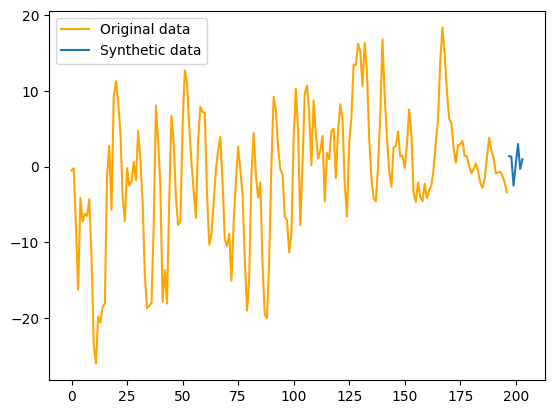

In [ ]:
x1 = np.arange(0,len(residual_cp3_washed))

end = len(residual_cp3_washed) + len(new_y_combined_reshaped)
x2 = np.arange(len(residual_cp3_washed),end)

plt.plot(x1,residual_cp3_washed,color='orange')
plt.plot(x2,new_y_combined_reshaped)
plt.legend(['Original data','Synthetic data'])

In [ ]:
July_17 = mu_T[197] + new_y_combined_reshaped[0]
print(July_17)

July_18 = mu_T[198] + new_y_combined_reshaped[1]
print(July_18)

July_19 = mu_T[199] + new_y_combined_reshaped[2]
print(July_19)

July_20 = mu_T[200] + new_y_combined_reshaped[3]
print(July_20)

July_21 = mu_T[201] + new_y_combined_reshaped[4]
print(July_21)

July_22 = mu_T[202] + new_y_combined_reshaped[5]
print(July_22)

July_23 = mu_T[203] + new_y_combined_reshaped[6]
print(July_23)



[81.10238748]
[81.237907]
[77.71247518]
[80.74751826]
[83.67474575]
[80.49057061]
[81.5811466]


In [ ]:
import pandas as pd

dates = pd.date_range(start='2024-04-01', periods=7, freq='D')

temps = [81.10238748, 81.237907, 77.71247518, 80.74751826, 83.67474575, 80.49057061, 81.5811466]

# Create a DataFrame with the date range and temp values
tempout = pd.DataFrame({'Temp': temps})

tempout.index = tempout.index + 1

print(tempout)

        Temp
1  81.102387
2  81.237907
3  77.712475
4  80.747518
5  83.674746
6  80.490571
7  81.581147


**OPERATIONALIZING THE FORECAST**

After you develop a 7-day forecast of peak elecricity demand, the utility (you) must translate this forecast into a plan for how to meet peak electricity demand at the lowest possible cost.

The problem of minimizing the cost of operating a power system is generally referred to as a **"unit commitment and economic dispatch"** problem.

It can be written more or less as follows:

$minimize \sum \limits_{g}^{G} \sum \limits_{d=1}^{7} [
  X_{g,d}*MC_{g} + Y_{g,d}*FC_{g} + Z_{g,d}*SC_{g}]$

Where,

> $g$ is a generator in the set of generators $G$ that are under the utility's control

> $d$ is a day in the forecast horizon $\in$ {$1,2,..7$}

> $X_{g,d}$ is a continuous decision variable representing the amount of electricity (in MWh) produced by generator $g$ in day $d$ peak hour

> $MC_{g}$ is the marginal cost (in dollars/MWh) of electricity at plant $g$

> $Y_{g,d}$ is a binary decision variable representing the on/off status of generator $g$ in day $d$ peak hour

> $FC_{g}$ is the fixed operating cost (in dollars) of plant $g$

> $Z_{g,d}$ is a binary decision variable representing the start status of generator $g$ in day $d$ peak hour

> $SC_{g}$ is the cost (in dollars) of starting plant $g$

The cost minimization is subject to several constraints, namely:

> Electricity production must meet demand

> $\sum \limits_{g}^{G} X_{g,d} > D_{d}$ $\forall$ $d$ $\in$ {$1,2,...7$}

> Electricity production at each plant must be within its given capacity limits

> $X_{g,d} <= Cap_{g}$ $\forall$ $g$ $\in$ $G$, $d$ $\in$ {$1,2,...7$}

The primary inputs to the optimization problem are $G, Cap_g, MC_g, FC_g, SC_g$, and $D_d$.

For the purposes of this final project, I will provide all required code for setting up and running the optimization, as well as all numerical inputs *except* $D_d$. **$D_d$ is the demand forecast that you have to determine.**

You need create the forecast and store it in a very specific format, like this:

![picture](https://drive.google.com/uc?export=view&id=1v6FqxNxuJjOQ0d0I4XJxRcG-UUiOAeWk)

The forecast should be stored as a comma delimited (.csv) file called '7_day_forecast.csv'.


**NEXT STEPS**

> I will post the optimization code later this week.

> In class sessions on **Apr 11, 16, 18, and 23** will be devoted to working on the project. I will attend class to answer questions, help debug code, and strategize.

> **1 extra 45-minute help session per team, per week (3 total)** can be scheduled by each team, at their discretion.  

**GRADING**

I haven't totally finalized this, but it will be a combination of:

1. Code completion

2. Model accuracy (ranked among teams, to make things a little competitive)

3. Final presentation quality (explanation of methods and results) -- more details on this later.

#Taking the Weather Forecast and Predicting Demand

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/romulus97/ISE437/main/daily_2019.csv',header=0)
df_cleaned = df.dropna()
#Remove outliers (outside 3 standard deviations)
def remove_outliers_z_score(data):
    threshold = 3
    z_scores = np.abs((data - data.mean()) / data.std())
    return data[(z_scores <= threshold).all(axis=1)]

df_cleaned = remove_outliers_z_score(df_cleaned)
df_cleaned.reset_index(drop=True, inplace=True)

dataset = df_cleaned.values

# separate into X and y data
X_array = dataset[:,0:2]
y_array = dataset[:,2]

# convert to pytorch tensors
X = torch.tensor(X_array, dtype=torch.float32)
y = torch.tensor(y_array, dtype=torch.float32).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25)

train = np.column_stack((X_train,y_train))
test = np.column_stack((X_test,y_test))

#Random Forest Model

<ipython-input-86-065e8bdc6ba0>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regressor.fit(X_train, y_train)


RF_MSE: 1046929.3423647786
RF_MAE: 839.5677837457906
RF_R2: 0.8832075535699095


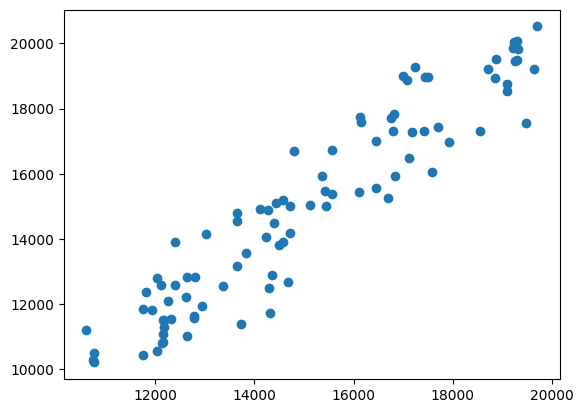

In [ ]:
# Initialize arrays to store min_samples_split and corresponding MAE values
min_samples_splits = []
mae_values = []

# create a regressor object
regressor = RandomForestRegressor(random_state = 0,min_samples_split=8)

# fit the regressor with X and Y data
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

plt.scatter(y_pred, y_test)

RF_MSE = mean_squared_error(y_test,y_pred)
RF_MAE = mean_absolute_error(y_test,y_pred)
RF_r2_score = r2_score(y_test, y_pred)

print("RF_MSE:", RF_MSE)
print("RF_MAE:", RF_MAE)
print("RF_R2:", RF_r2_score)



In [ ]:
data = {
    'Temp': tempout['Temp'].values.tolist()  # Read the 'Temp' values from 'tempout'
}
weather_predictions = pd.DataFrame(data)
# Calculate the day of the week values, looping around to 1 after reaching 7
day_of_week_values = [(day % 7) + 1 for day in range(4, 4 + len(data['Temp']))]
# Add the 'day_of_week' column to the DataFrame
weather_predictions['day_of_week'] = day_of_week_values
weather_predictions = weather_predictions[['day_of_week', 'Temp']]
weather_predictions

,day_of_week,Temp
0,5,81.102387
1,6,81.237907
2,7,77.712475
3,1,80.747518
4,2,83.674746
5,3,80.490571
6,4,81.581147


In [ ]:
X_inputs = weather_predictions.iloc[:,0:2].values
X_preds = torch.tensor(X_inputs, dtype=torch.float32)


In [ ]:
output_predictions = regressor.predict(X_preds)
output_predictions

array([19086.3732773 , 17967.37018143, 17333.46108424, 19582.23228925,
       20182.99500067, 19293.43053854, 18943.44273255])

In [ ]:
df = pd.DataFrame({'day': [5, 6, 7, 1, 2, 3, 4], 'value': output_predictions})

df

,day,value
0,5,19086.373277
1,6,17967.370181
2,7,17333.461084
3,1,19582.232289
4,2,20182.995001
5,3,19293.430539
6,4,18943.442733


In [ ]:
# Export DataFrame to CSV
df.to_csv('7_day_forecast_team4.csv', index=False)

print("DataFrame has been exported to '7_day_forecast_team4.csv'.")

files.download("7_day_forecast_team4.csv")

DataFrame has been exported to '7_day_forecast_team4.csv'.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>